In [1]:
import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras

from FyeldGenerator import generate_field
import colorcet as cc

INFO:2025-10-23 16:00:01,387:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:bayesflow:Using backend 'jax'


In [2]:
def generate_power_spectrum(alpha, scale):
    def power_spectrum(k):
        base = np.power(k, -alpha) * scale**2
        return base

    return power_spectrum


def distribution(shape=(32, 32)):
    a = np.random.normal(loc=0, scale=1., size=shape)
    b = np.random.normal(loc=0, scale=1., size=shape)
    return a + 1j * b

In [3]:
shape = (32, 32)
n_examples = 5
alphas = np.linspace(2, 5, n_examples)
spectra = [generate_power_spectrum(alpha, 1) for alpha in alphas]

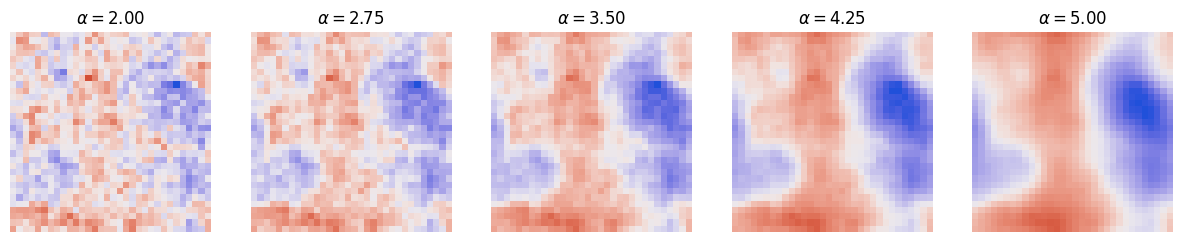

In [4]:
def plot_distribution(shape=shape):
    rng = np.random.default_rng(seed=42)
    a = rng.normal(loc=0, scale=1., size=shape)
    b = rng.normal(loc=0, scale=1., size=shape)
    return a + 1j * b
fig, axs = plt.subplots(1, n_examples, figsize=(n_examples * 3, 4))

for power_spectrum, alpha, ax in zip(spectra, alphas, axs):
    
    field = generate_field(plot_distribution, power_spectrum, shape)
    max_magnitude = np.max(np.abs(field))
    ax.imshow(field, cmap=cc.cm.coolwarm, vmin=-max_magnitude, vmax=max_magnitude)
    ax.set_title(f"$\\alpha={alpha:.2f}$")
    ax.set_axis_off()

In [5]:
rng = np.random.default_rng()


def prior():
    log_std = rng.normal(scale=0.3)
    alpha = rng.normal(loc=3, scale=0.5)
    params_expanded = np.array([log_std, alpha])
    params_expanded = np.ones(shape + (2,)) * params_expanded[None, None, :]
    return {
        "log_std": log_std,
        "alpha": alpha,
        "params_expanded": params_expanded
    }


def likelihood(log_std, alpha):
    field = generate_field(
        distribution, generate_power_spectrum(alpha, np.exp(log_std)), shape
    )

    return {"field": field[..., None] / 50.}


simulator = bf.make_simulator([prior, likelihood])

In [6]:
@bf.utils.serialization.serializable("custom")
class ResNetSubnet(bf.networks.SummaryNetwork):
    def __init__(
        self,
        widths=(8, 16, 32),
        activation="mish",
        **kwargs,
    ):

        super().__init__(**kwargs)

        layers = [keras.layers.Conv2D(width, kernel_size=3, activation=activation, padding='SAME') for width in widths]
        self.net = bf.networks.Sequential(layers)

    def build(self, x_shape, t_shape, conditions_shape):
        self.net.build(x_shape[:-1] + (4,))

    def call(self, x, t, conditions, training=False):
        t = keras.ops.broadcast_to(t, keras.ops.shape(x)[:-1] + (1,))
        return self.net(keras.ops.concatenate((x, t, conditions), axis=-1), training=training)
    
    def compute_output_shape(self, x_shape, t_shape, conditions_shape):
        return x_shape[:-1] + (32,)

In [7]:
training_data = simulator.sample(5000)
validation_data = simulator.sample(50)

In [8]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .rename("params_expanded", "inference_conditions")
    .rename("field", "inference_variables")
)

# Test Training

In [ ]:
inference_network = bf.networks.DiffusionModel(subnet=ResNetSubnet, concatenate_subnet_input=False)

workflow = bf.workflows.BasicWorkflow(
    simulator=simulator,
    inference_network=inference_network,
    adapter=adapter,
    standardize=None,
)

In [10]:
history = workflow.fit_offline(
    data=training_data,
    epochs=100,
    validation_data=validation_data,
    batch_size=16,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2709 - val_loss: 0.7012
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 0.7666 - val_loss: 0.4453
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 0.3224 - val_loss: 0.1734
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 0.1693 - val_loss: 0.1401
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 0.1251 - val_loss: 0.0971
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 0.1100 - val_loss: 0.0905
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 0.0941 - val_loss: 0.0649
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 0.0879 - val_loss: 0.0696
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 0.0763 - val_loss: 0.0779
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.0768 - val_loss: 0.1486
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0644 - val_loss: 0.0536
Epoch 12/100
313/313 

KeyboardInterrupt: 

In [57]:
workflow.approximator.inference_network.base_distribution.dims

(32, 32, 1)

In [60]:
inference_network is workflow.approximator.inference_network

True

In [58]:
validation_data = simulator.sample(1)

In [74]:
z = keras.random.normal((1, 32, 32, 1))
conditions = keras.ops.convert_to_tensor(validation_data["params_expanded"], dtype="float32")


sample = inference_network(z, conditions=conditions, inverse=True)

In [75]:
sample = keras.ops.convert_to_numpy(sample)

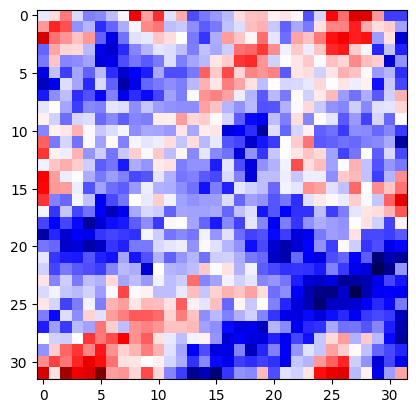

In [76]:
plt.imshow(sample[0], cmap="seismic")

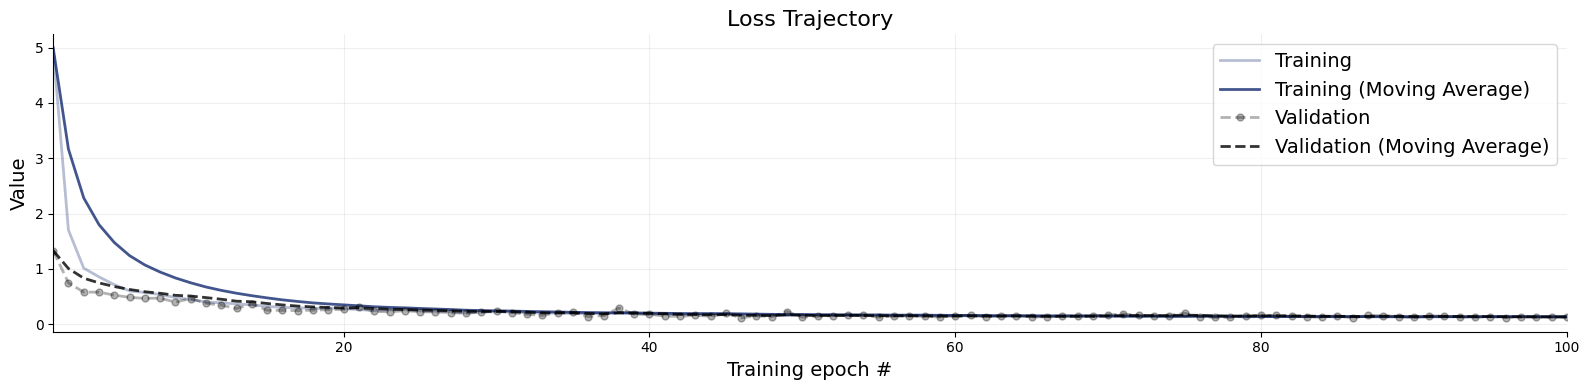

In [65]:
f = bf.diagnostics.plots.loss(history)

In [ ]:
small_training_data = {k: v[:100] for k,v in training_data.items()}

workflow.plot_custom_diagnostics(
    test_data=test_data,
    plot_fns={
        "recovery": bf.diagnostics.recovery,
        "calibration": bf.diagnostics.calibration_ecdf,
    },
)

# Evaluations

In [1]:
import numpy as np
import bayesflow as bf
import keras
import cnn

import matplotlib.pyplot as plt
from FyeldGenerator import generate_field
import colorcet as cc

Defaulting to JAX.
To override, set the KERAS_BACKEND environment variable before importing bayesflow.
See: https://keras.io/getting_started/#configuring-your-backend
INFO:2025-10-24 17:05:37,365:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/nielsbracher/miniconda3/envs/diffusion-exp/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/nielsbracher/miniconda3/envs/diffusion-exp/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:bayesflow

In [2]:
target = "NLE"
models = [
    "consistency_model",
    "diffusion_edm_vp",
    "flow_matching",
]
scales = [2**n for n in range(3, 9)]
model_configs = ["8_16", "32_64_128_256"]
checkpoint_paths = [
    f"{model}/{target}/checkpoints/{scale}_shape_config_{model_configs[0] if str(scale) in model_configs[0] else model_configs[1]}.keras"
    for model in models
    for scale in scales
]
print(checkpoint_paths)
checkpoint_path = checkpoint_paths[0]
current_shape = int(checkpoint_path.split("/")[-1].split("_")[0])
current_config = checkpoint_path.split("_shape_config_")[-1].split(".keras")[0]
approximator = keras.saving.load_model(checkpoint_path)
approximator.summary()

['consistency_model/NLE/checkpoints/8_shape_config_8_16.keras', 'consistency_model/NLE/checkpoints/16_shape_config_8_16.keras', 'consistency_model/NLE/checkpoints/32_shape_config_32_64_128_256.keras', 'consistency_model/NLE/checkpoints/64_shape_config_32_64_128_256.keras', 'consistency_model/NLE/checkpoints/128_shape_config_32_64_128_256.keras', 'consistency_model/NLE/checkpoints/256_shape_config_32_64_128_256.keras', 'diffusion_edm_vp/NLE/checkpoints/8_shape_config_8_16.keras', 'diffusion_edm_vp/NLE/checkpoints/16_shape_config_8_16.keras', 'diffusion_edm_vp/NLE/checkpoints/32_shape_config_32_64_128_256.keras', 'diffusion_edm_vp/NLE/checkpoints/64_shape_config_32_64_128_256.keras', 'diffusion_edm_vp/NLE/checkpoints/128_shape_config_32_64_128_256.keras', 'diffusion_edm_vp/NLE/checkpoints/256_shape_config_32_64_128_256.keras', 'flow_matching/NLE/checkpoints/8_shape_config_8_16.keras', 'flow_matching/NLE/checkpoints/16_shape_config_8_16.keras', 'flow_matching/NLE/checkpoints/32_shape_conf

Model: "continuous_approximator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ consistency_model               │ ?                      │        19,714 │
│ (ConsistencyModel)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,141 (231.02 KB)

 Trainable params: 19,713 (77.00 KB)

 Non-trainable params: 1 (4.00 B)

 Optimizer params: 39,427 (154.01 KB)

In [3]:
rng = np.random.default_rng()
shape = (current_shape, current_shape)

def generate_power_spectrum(alpha, scale):
    def power_spectrum(k):
        base = np.power(k, -alpha) * scale**2
        return base
    return power_spectrum

def distribution(shape):
    a = np.random.normal(loc=0, scale=1., size=shape)
    b = np.random.normal(loc=0, scale=1., size=shape)
    return a + 1j * b

def prior():
    log_std = rng.normal(scale=0.3)
    alpha = rng.normal(loc=3, scale=0.5)
    params_expanded = np.array([log_std, alpha])
    params_expanded = np.ones(shape + (2,)) * params_expanded[None, None, :]
    return {
        "log_std": log_std,
        "alpha": alpha,
        "params_expanded": params_expanded
    }


def likelihood(log_std, alpha):
    field = generate_field(
        distribution, generate_power_spectrum(alpha, np.exp(log_std)), shape
    )

    return {"field": field[..., None] / 50.}


simulator = bf.make_simulator([prior, likelihood])

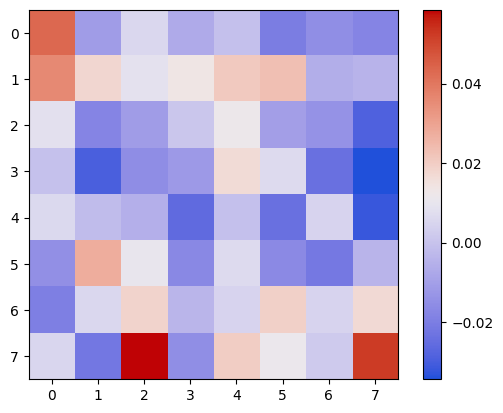

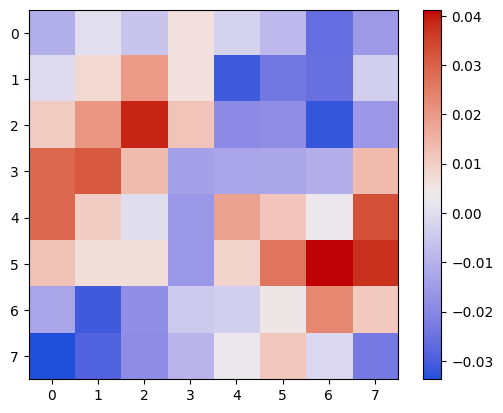

In [53]:
validation_data = simulator.sample(1)
z = keras.random.normal((1, current_shape, current_shape, 1))
conditions = keras.ops.convert_to_tensor(validation_data["params_expanded"], dtype="float32")
sample = approximator.inference_network(z, conditions=conditions, inverse=True)
plt.figure()
plt.imshow(sample[0, :, :, 0], cmap=cc.cm.coolwarm)
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(validation_data["field"][0, :, :, 0], cmap=cc.cm.coolwarm)
plt.colorbar()
plt.show()

In [40]:
def generate_classifier_data(approximator, simulator, n_samples=100):
    data = simulator.sample(n_samples)
    z = keras.random.normal((n_samples, current_shape, current_shape, 1))
    conditions = keras.ops.convert_to_tensor(data["params_expanded"], dtype="float32")
    samples = approximator.inference_network(z, conditions=conditions, inverse=True)
    return {
        "simulated": data["field"],
        "generated": keras.ops.convert_to_numpy(samples),
    }

In [71]:
from resnet import ResNetSummary
classifier_kwargs = {
        "shape_config_32_64_128_256": {
            "summary_kwargs": {
                "summary_dim": 1,
                "widths": [16, 16],
                "use_batch_norm": False,
                "dropout": 0.0,
            },
        },
        "shape_config_8_16": {
            "summary_kwargs": {
                "summary_dim": 1,
                "widths": 2*(8,),
                "use_batch_norm": False,
                "dropout": 0.0,
            },
        }
    }

def make_classifier(current_shape, current_config):
    inputs = keras.Input(current_shape)
    outputs = ResNetSummary(**classifier_kwargs[f"shape_config_{current_config}"]["summary_kwargs"])(inputs)
    return keras.Model(inputs=inputs, outputs=outputs)

classifier = make_classifier((current_shape, current_shape, 1), current_config)
classifier.summary()


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_summary_12              │ (1, 1)                 │         1,841 │
│ (ResNetSummary)                 │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,841 (7.19 KB)

 Trainable params: 1,841 (7.19 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
epochs = 100
classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)
traindata = generate_classifier_data(approximator, simulator, n_samples=10000)
x = np.concatenate(
    [traindata["simulated"], traindata["generated"]], axis=0
)
y = np.concatenate(
    [np.ones((traindata["simulated"].shape[0], 1)), np.zeros((traindata["generated"].shape[0], 1))],
    axis=0,
)
validation_data = generate_classifier_data(approximator, simulator, n_samples=100)
x_val = np.concatenate(
    [validation_data["simulated"], validation_data["generated"]], axis=0
)
y_val = np.concatenate(
    [np.ones((validation_data["simulated"].shape[0], 1)), np.zeros((validation_data["generated"].shape[0], 1))],
    axis=0,
)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 972us/step - accuracy: 0.5000 - loss: 0.6894 - val_accuracy: 0.5000 - val_loss: 0.6694
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - accuracy: 0.7587 - loss: 0.3939 - val_accuracy: 0.9300 - val_loss: 0.2200
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step - accuracy: 0.9444 - loss: 0.1658 - val_accuracy: 0.9250 - val_loss: 0.1616
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step - accuracy: 0.9550 - loss: 0.1320 - val_accuracy: 0.9300 - val_loss: 0.1515
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - accuracy: 0.9579 - loss: 0.1210 - val_accuracy: 0.9200 - val_loss: 0.1530
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step - accuracy: 0.9594 - loss: 0.1167 - val_accuracy: 0.9200 - val_loss: 0.1607
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.9596 - loss: 0.1139 - val_accuracy: 0.9200 - val_loss: 0.1531
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 

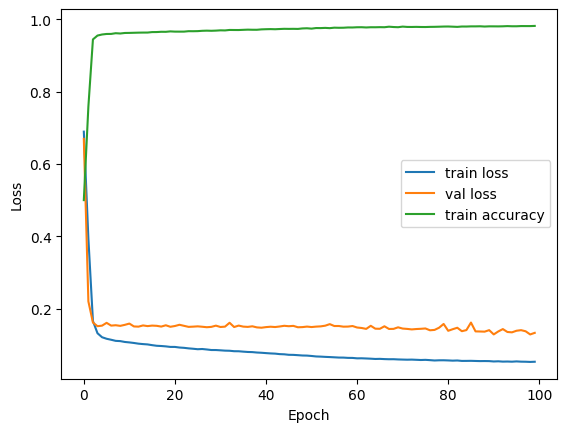

In [73]:
history=classifier.fit(
    x,
    y,
    epochs=epochs,
    batch_size=16,
    validation_data=(x_val, y_val),
)
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.plot(history.history["accuracy"], label="train accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

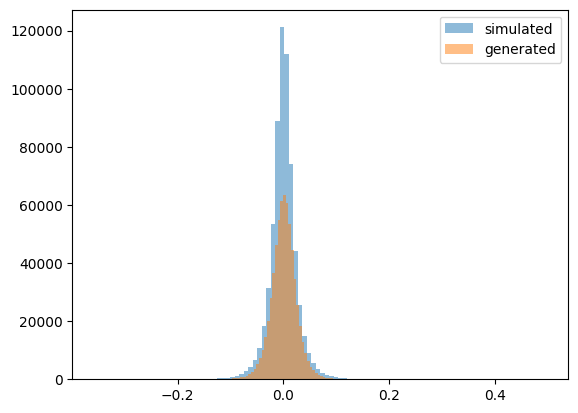

In [55]:
plt.figure()
plt.hist(traindata["simulated"].flatten(), bins=100, alpha=0.5, label="simulated")
plt.hist(traindata["generated"].flatten(), bins=100, alpha=0.5, label="generated")
plt.legend()
plt.show()